In [9]:
import sys
# import numpy as np
# import matplotlib.pyplot as plt
import pandas as pd
# import lightkurve as lk
# from scipy.optimize import curve_fit

# from astropy.convolution import Gaussian1DKernel
# from astropy.convolution import convolve
sys.path.insert(0, "../")

from michael import janet

In [10]:
uni = pd.read_csv("/Users/oliver hall/Research/unicorn/data/unicorn.csv", index_col=0)

Index 258 is a good tester. Clear rotational signal, ambiguous peak mode.

In [11]:
j = janet.boot(uni, index=258)

Already have data downloaded for Gaia ID 1923544057484996224.
If you want to check for new data, run `janet.update()`.
### Running Simple Astropy Lomb-Scargle on Sector 16 on star 1923544057484996224 ###
### Completed Simple Astropy Lomb-Scargle for Sector 16 on star 1923544057484996224 ###
### Saved results ###
### Running Simple Astropy Lomb-Scargle on Sector 17 on star 1923544057484996224 ###
### Completed Simple Astropy Lomb-Scargle for Sector 17 on star 1923544057484996224 ###
### Saved results ###
### Running Simple Astropy Lomb-Scargle on Sector all on star 1923544057484996224 ###
### Completed Simple Astropy Lomb-Scargle for Sector all on star 1923544057484996224 ###
### Saved results ###
### Running Wavelet Estimation on star 1923544057484996224 ###


  0%|          | 0/754 [00:00<?, ?it/s]

### Completed Wavelet Estimation on star 1923544057484996224 ###
### Saved results ###
### Running ACF Estimation on star 1923544057484996224 ###
### Completed ACF Estimation on star 1923544057484996224 ###
### Saved results ###
### Saved results ###
### Saved results ###
### Saved results ###
### Saved results ###


KeyError: 'wt'

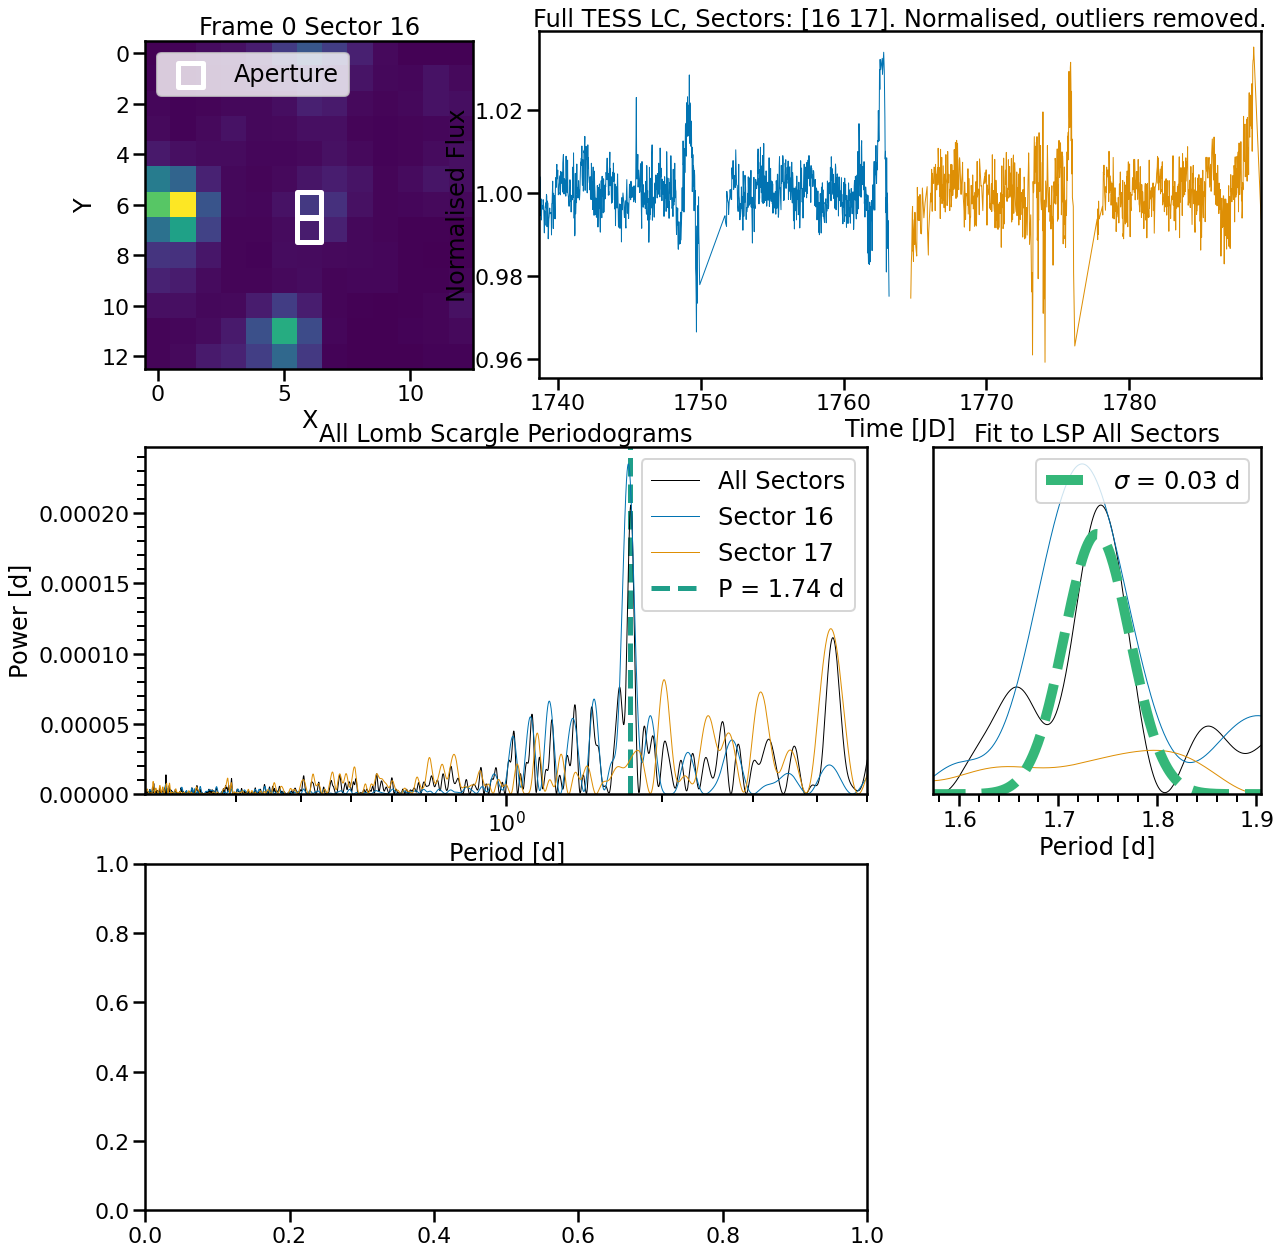

In [12]:
j.run(period_range = (0.2, 5))

In [13]:
j.results

,SLS,e_SLS,f_SLS,SW,e_SW,ACF,s_SLS,overall,e_overall,f_overall
16,1.724326,0.047084,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,4.264821,0.202666,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
all,1.739096,0.033148,0.0,1.748756,0.292399,1.708382,NaN,NaN,NaN,NaN
best,1.739096,0.033148,0.0,1.748756,0.292399,NaN,all,1.739096,0.033148,1.0


In [ ]:
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt

import pymc3 as pm

In [ ]:
acfsmoo = j.void['acfsmoo']
wt = j.void['wt']
nus = wt.nus
wwz = j.void['wwz']

In [ ]:
acfsmoolc = lk.LightCurve(time = j.void['acflc'].time.value, flux = acfsmoo)

In [ ]:
Model = pm.Model()
P = acfsmoolc.time.value
F = acfsmoolc.flux.value

with Model:
    A0 = pm.Uniform('A0', 0., 1., testval=0.05)
    A1 = pm.Uniform('A1', 0., 10., testval=0.5)
    yy = pm.Deterministic('yy', (1-A0)*np.exp(-P/A1) + A0)
    y = pm.Normal('like', mu=yy, sigma = np.std(F),
                 observed=F)

In [ ]:
with Model:
    trace = pm.sample()

In [ ]:
yy = np.median(trace['yy'], axis=0)
normacf = acfsmoolc - yy

In [ ]:
binned = normacf.bin()